<a href="https://colab.research.google.com/github/xinhe-zhang/heatwave/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **IPCS Heatwave HW1**
張昕荷 地理碩一 R12228016

***

Search two heatwave news, plot it and write what you have observed.
## **Event 1 : 2020 Siberia Heatwave**
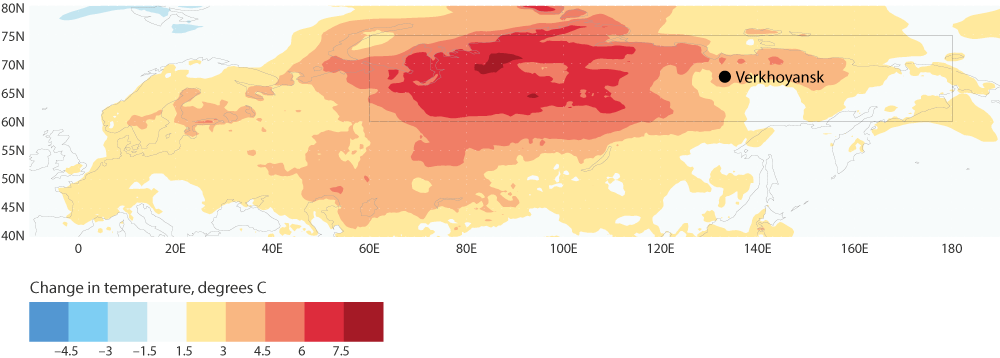

**Fig.1**
*Prolonged Siberian heat: January – June 2020 average temperatures compared to normal (1981-2010) over the Siberian region used in the study (box), and the location of the town of Verkhoyansk that experienced the record June daily temperature within the Arctic circle.(Courtesy of World Weather Attribution)*

In the first six months of 2020, Siberia experienced a period of unusually high temperatures, including a record-breaking 38 degrees C in the town of Verkhoyansk on 20 June, causing wide-scale impacts including wildfires, loss of permafrost, and an invasion of pests.

Reference:

https://www.worldweatherattribution.org/siberian-heatwave-of-2020-almost-impossible-without-climate-change/

https://climate.copernicus.eu/esotc/2020/heat-siberia



In [1]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import axis as axis
import matplotlib.dates as mdates
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from datetime import datetime
from matplotlib.dates import DateFormatter

!pip install cartopy
import cartopy.crs as ccrs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 48.1 MB/s eta 0:00:00


In [2]:
#Download ERA5 Tmax, 1979-2022, land only, 144*73
#I've changed the data to my own drive.
!gdown https://drive.google.com/u/1/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu&export=download

Downloading...
From: https://drive.google.com/u/1/uc?id=14okWeTrUH1nHZcgbmBZupRM6s5EcVoYu
To: /content/ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc
100% 676M/676M [00:03<00:00, 204MB/s]


In [3]:
filename = 'ERA5_SFC_mx2t_1979-2022_r144x73_day.land.nc'
ds = xr.open_dataset(filename)

In [4]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 16071, lon: 144, lat: 73)
Coordinates:
  * time     (time) int32 19790101 19790102 19790103 ... 20221230 20221231
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Data variables:
    mx2t     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Sep 05 13:41:31 2023: cdo chname,t2m,mx2t ERA5_SFC_mx2t...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


In [5]:
print(ds['mx2t'])

<xarray.DataArray 'mx2t' (time: 16071, lat: 73, lon: 144)>
[168938352 values with dtype=float32]
Coordinates:
  * time     (time) int32 19790101 19790102 19790103 ... 20221230 20221231
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
Attributes:
    units:    m


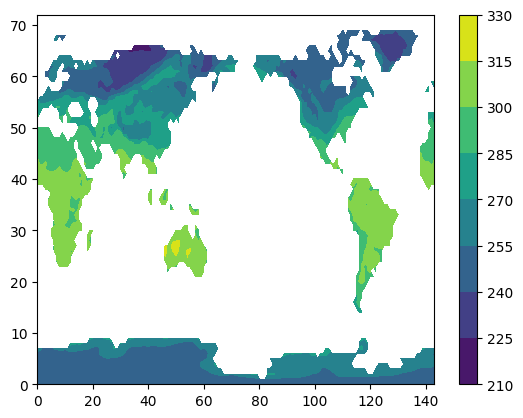

In [6]:
#Quick check
plt.contourf(ds['mx2t'][0,:,:])
plt.colorbar()

In [7]:
# Convert Kelvin to Celsius
ds = ds - 273.15

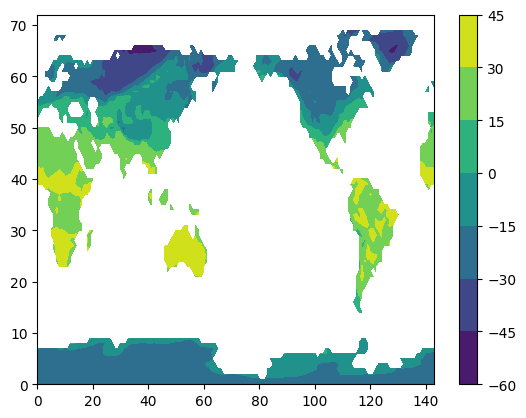

In [8]:
#Check again
plt.contourf(ds['mx2t'][0,:,:])
plt.colorbar()

In [9]:
#Write the time format
ds['time'] = ds['time'].astype('datetime64[ns]')
print(ds['time'].dtype)
print(ds['time'])

start_date = np.datetime64('1979-01-01')
end_date = np.datetime64('2023-01-01')  # Adjust the end date as needed

# Create a time array with intervals of 1 day
time_array = np.arange(start_date, end_date, np.timedelta64(1, 'D'))

print(time_array)
ds['time'] = time_array

datetime64[ns]
<xarray.DataArray 'time' (time: 16071)>
array(['1970-01-01T00:00:00.019790101', '1970-01-01T00:00:00.019790102',
       '1970-01-01T00:00:00.019790103', ..., '1970-01-01T00:00:00.020221229',
       '1970-01-01T00:00:00.020221230', '1970-01-01T00:00:00.020221231'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T00:00:00.019790101 ... 1970-01-...
Attributes:
    standard_name:  time
    long_name:      Date
    units:          day as %Y%m%d.%f
    calendar:       proleptic_gregorian
    axis:           T
['1979-01-01' '1979-01-02' '1979-01-03' ... '2022-12-29' '2022-12-30'
 '2022-12-31']


In [10]:
#Select the month and location
ds_t2m=ds.sel(time=ds.time.dt.month.isin([6])).sel(lat=67.5, lon=130, method="nearest")

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [11]:
mx2t = ds_t2m['mx2t']
print(mx2t)

<xarray.DataArray 'mx2t' (time: 1320)>
array([ 2.6732178 ,  0.39715576,  1.433136  , ...,  5.6553345 ,
       14.040558  , 13.56839   ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2022-06-30
    lon      float64 130.0
    lat      float64 67.5


In [12]:
#filter 2020 June
x_2020_max = mx2t.sel(time=slice('2020-06-01', '2020-06-30'))
print(x_2020_max)
#now we got data only in the 30 days in June, 2020

<xarray.DataArray 'mx2t' (time: 30)>
array([ 9.525879 , 10.940521 ,  9.943268 ,  7.0035706, 12.126099 ,
       16.367584 , 18.905792 , 19.417328 , 14.270233 ,  3.7114868,
       11.85788  , 14.485016 , 15.052765 , 19.041107 , 16.863617 ,
       18.66867  , 20.802094 , 22.38266  , 24.947235 , 27.151031 ,
       28.141815 , 25.965271 , 26.225433 , 26.054504 , 25.74002  ,
       24.923676 , 25.255829 , 24.777466 , 20.811737 , 23.30014  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2020-06-30
    lon      float64 130.0
    lat      float64 67.5


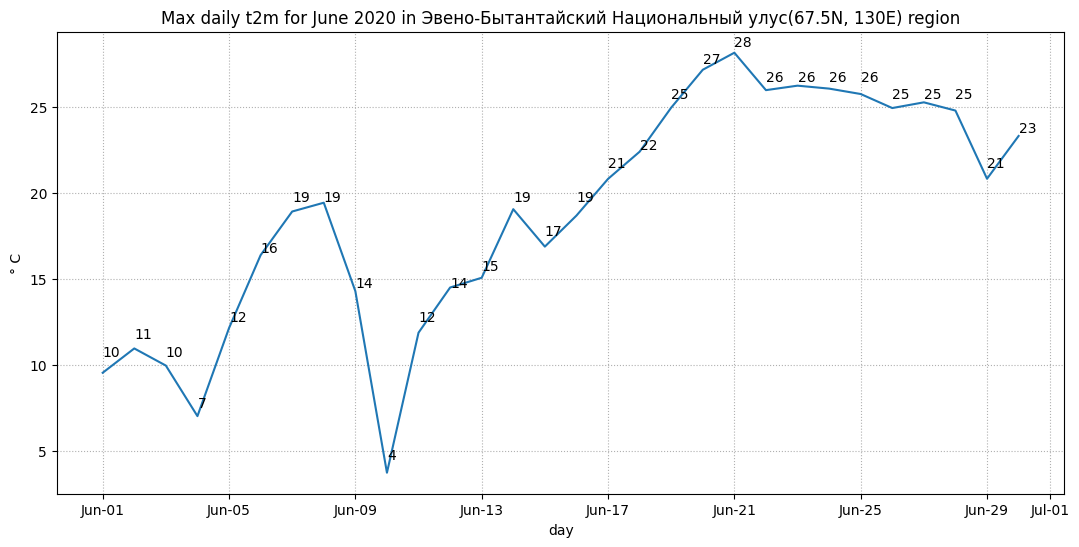

In [13]:
#a line plot that shows temperature fluctuation in June, 2002
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
ax.plot(x_2020_max.time, x_2020_max)
ax.set_title('Max daily t2m for June 2020 in Эвено-Бытантайский Национальный улус(67.5N, 130E) region')
ax.set_ylabel('° C')
ax.set_xlabel('day')
ax.grid(linestyle='dotted')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#put the max.T value on each point
for i,j in zip(x_2020_max.time, np.around(x_2020_max.values, 0).astype(int)):
    ax.annotate(str(j),xy=(i,j+0.5))


In [14]:
print('The maximum temperature in June 2020 in this area was',
      np.around(x_2020_max.max().values, 2), 'degrees Celsius.')

The maximum temperature in June 2020 in this area was 28.14 degrees Celsius.


**Fig.2**
*This plot shows the temperature variation in June 2020 at the location (67.5N, 130E), represented by the daily maximum two-meter temperature. There was a minor warming trend from June 4th to June 8th, followed by a sudden drop in temperature. Starting from June 10th, temperatures began to rise continuously, reaching a peak of 28.14°C on June 21st and remaining in a high-temperature state until the end of June.*

In [15]:
#select data before 2020(included)
x_past = mx2t.loc['1979':'2020']
print(x_past)

<xarray.DataArray 'mx2t' (time: 1260)>
array([ 2.6732178 ,  0.39715576,  1.433136  , ..., 24.777466  ,
       20.811737  , 23.30014   ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2020-06-30
    lon      float64 130.0
    lat      float64 67.5


In [16]:
#select 10, 50, 90 quantile from the past
x_max_mid = mx2t.groupby('time.day').quantile(0.5)
x_max_90  = mx2t.groupby('time.day').quantile(0.9)
x_max_10  = mx2t.groupby('time.day').quantile(0.1)
print(x_max_10)
print(x_max_mid)
print(x_max_90)

<xarray.DataArray 'mx2t' (day: 30)>
array([1.43351746, 0.01387329, 1.5532074 , 2.26946411, 2.60884399,
       1.64988708, 2.79572144, 2.23360291, 2.78508301, 4.52483826,
       4.59788208, 2.64448547, 5.80215149, 5.78617554, 4.00228882,
       6.84390869, 7.74862366, 6.25111694, 5.06247253, 5.18581543,
       4.42095642, 4.09113159, 5.07986755, 6.62155457, 7.35142517,
       7.33447571, 5.73787842, 8.49860229, 7.58200989, 9.0649353 ])
Coordinates:
    quantile  float64 0.1
  * day       (day) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29 30
<xarray.DataArray 'mx2t' (day: 30)>
array([ 8.13929749,  8.76219177,  9.35714722,  7.97956848,  9.17919922,
        9.98014832,  9.47103882, 10.81039429, 11.3681488 , 11.00364685,
       11.35986328, 13.46394348, 13.45100403, 13.29275513, 13.16325378,
       13.46987915, 14.81951904, 15.21989441, 15.15814209, 13.76452637,
       14.23878479, 13.02366638, 12.59794617, 14.55392456, 13.99278259,
       13.98143005, 14.51524353, 16.9311676 ,

/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
<ipython-input-17-a9a17e45e077>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(x_2020_max.time.dt.day, x_2020_max, 'bo-', color='darkred', label='Daily max t2m June 2020')


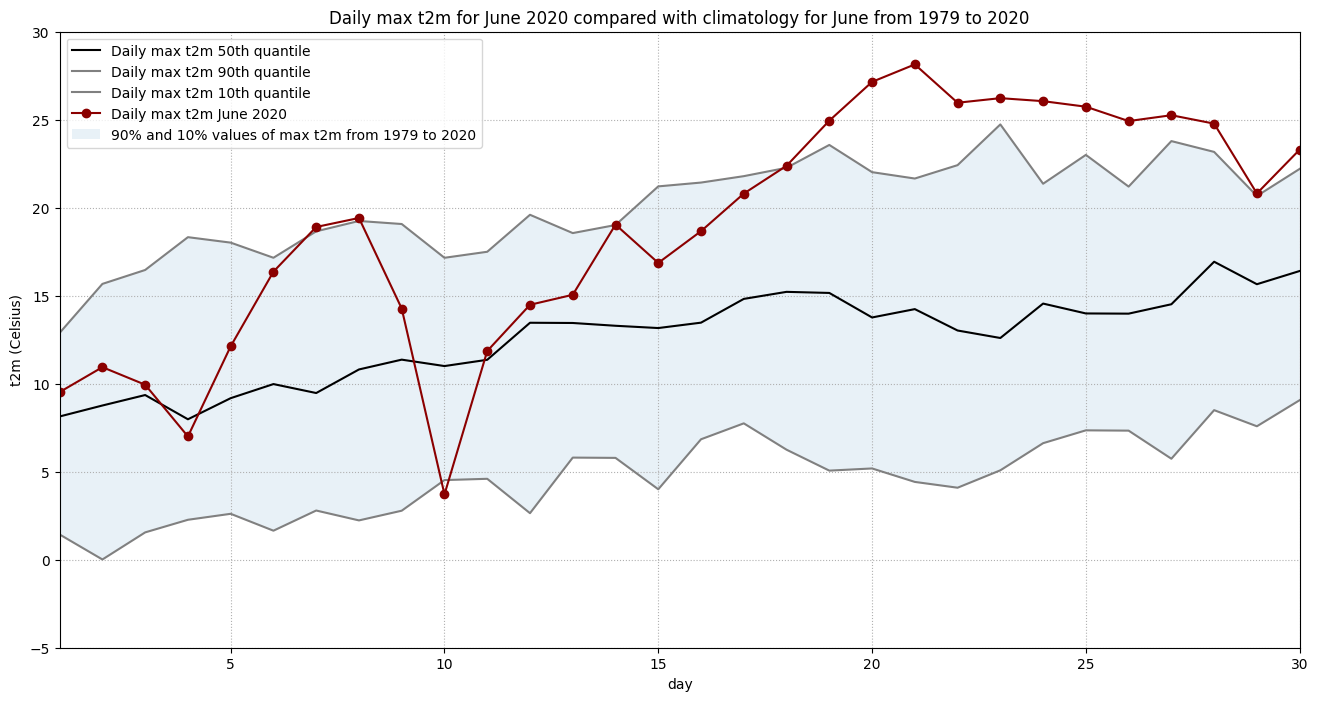

In [17]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()

ax.plot(x_2020_max.time.dt.day, x_max_mid, color='black', label='Daily max t2m 50th quantile')
ax.plot(x_2020_max.time.dt.day, x_max_90, color='gray', label='Daily max t2m 90th quantile')
ax.plot(x_2020_max.time.dt.day, x_max_10, color='gray', label='Daily max t2m 10th quantile')
ax.plot(x_2020_max.time.dt.day, x_2020_max, 'bo-', color='darkred', label='Daily max t2m June 2020')
ax.fill_between(x_2020_max.time.dt.day, x_max_90, x_max_10, alpha=0.1,
                label='90% and 10% values of max t2m from 1979 to 2020')

ax.set_xlim(1,30)
ax.set_ylim(-5,30)
ax.set_title('Daily max t2m for June 2020 compared with climatology for June from 1979 to 2020')
ax.set_ylabel('t2m (Celsius)')
ax.set_xlabel('day')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='dotted')

**Fig.3**
*To better understand whether there were indeed unusual temperature changes in June 2020 compared to previous years, Fig.2 shows the historical temperature range for this location from 1979 to June 2020, with the upper and lower bounds corresponding to the 90th and 10th quantiles, respectively. It can be observed that the slight warming from June 4th to June 8th generally remained within the 90th percentile range. However, during June 19th to June 30th, temperatures exceeded the 90th quantile line almost every day, indicating the occurrence of a heatwave during that period. Additionally, there was an unusual drop in temperature on June 10th, conveniently situated between the two warming events.*

Then we will inspect the probability distribution of maximum temperatures for 21 June in this time period. To do this, we will first select only the max daily temperature for 21 June, for each year in the time series:

In [18]:
#selct only data on 21 June
x_21 = mx2t[20::30] #start from index 20, for an interval of 30
print(x_21)

<xarray.DataArray 'mx2t' (time: 44)>
array([ 7.522766 ,  8.411041 ,  1.9347229, 11.865509 , 14.327301 ,
       18.43863  , 10.553589 , 23.109161 ,  5.2833557, 15.658905 ,
        6.587158 , 15.538025 ,  4.2362976, 18.713165 , 14.150269 ,
       11.582001 , 13.834351 ,  4.345337 , 16.577393 , 22.337006 ,
       12.717163 ,  4.3958435,  9.413971 , 20.075287 ,  6.4478455,
        4.193512 , 17.294495 ,  9.981567 , 18.775085 , 16.57373  ,
       17.809265 , 13.926605 , 13.901184 ,  4.479553 , 16.964386 ,
       18.156647 , 14.956726 , 12.004974 , 16.299164 , 19.748383 ,
       23.049805 , 28.141815 , 26.396942 , 16.012604 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-21 1980-06-21 ... 2022-06-21
    lon      float64 130.0
    lat      float64 67.5


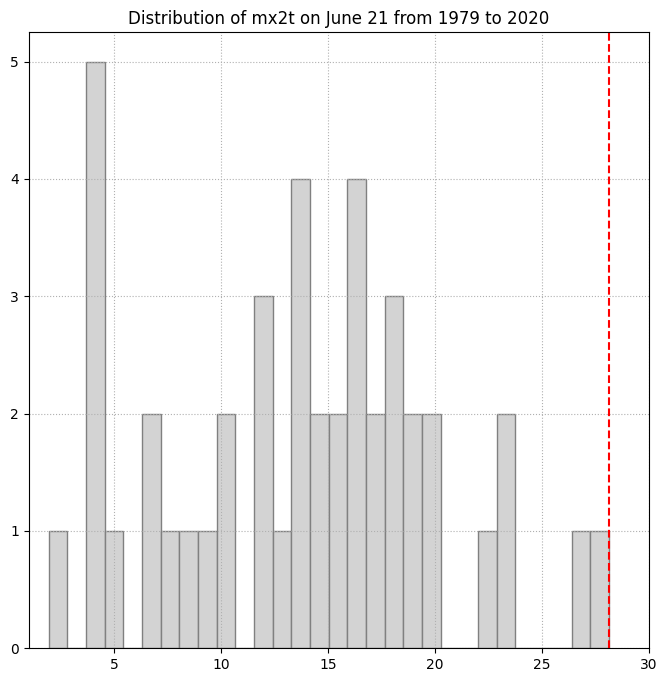

In [19]:
#plot the probability distribution
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
ax.hist(x_21, color='lightgrey', ec='grey',  bins=30)
ax.set_xlim(1,30)
ax.set_title('Distribution of mx2t on June 21 from 1979 to 2020')
plt.axvline(x = x_2020_max.max(), color = 'red', label = 'axvline - full height', linestyle='--')
ax.grid(linestyle='dotted')

**Fig.4**
*This plot shows the distribution of the maximum temperature on June 21 from 1979 to 2020. There are 44 samples. The dashed red line represents the maximum temperature in 2020 -- it is apparent that the temperature in the past has never exceeded it.*

In order to increase the number of samples, let's plot the histogram of maximum temperatures on 21 June, plus or minus three days(which are, 18 to 24 June). This would increase our number of samples by a factor of seven.

In [20]:
years = np.arange(44) #2022-1979=43 years
days_in_jun = np.arange(17,24)
index = np.zeros(308) #44*7

In [21]:
#calculate the index that marks those days
for i in years:
    index[i*7:(i*7)+7] = days_in_jun + (i*30)
index = index.astype(int)
print(index)

[  17   18   19   20   21   22   23   47   48   49   50   51   52   53
   77   78   79   80   81   82   83  107  108  109  110  111  112  113
  137  138  139  140  141  142  143  167  168  169  170  171  172  173
  197  198  199  200  201  202  203  227  228  229  230  231  232  233
  257  258  259  260  261  262  263  287  288  289  290  291  292  293
  317  318  319  320  321  322  323  347  348  349  350  351  352  353
  377  378  379  380  381  382  383  407  408  409  410  411  412  413
  437  438  439  440  441  442  443  467  468  469  470  471  472  473
  497  498  499  500  501  502  503  527  528  529  530  531  532  533
  557  558  559  560  561  562  563  587  588  589  590  591  592  593
  617  618  619  620  621  622  623  647  648  649  650  651  652  653
  677  678  679  680  681  682  683  707  708  709  710  711  712  713
  737  738  739  740  741  742  743  767  768  769  770  771  772  773
  797  798  799  800  801  802  803  827  828  829  830  831  832  833
  857 

In [22]:
#extract the data from those days
x_7days = mx2t.values[index]
print(x_7days)

[ 2.1192627   2.94339     5.1495056   7.522766   12.842682   16.586243
 16.382172   11.120422   16.234955   14.911652    8.411041    3.4847107
  8.040283   14.603638    7.6419067  11.469177   13.711212    1.9347229
  6.935028   15.3715515  17.584686   18.257477   19.85025    17.597961
 11.865509   12.409088    9.632202   13.017303   19.94873    17.19516
  5.284485   14.327301   11.978851   12.365906   15.340088   11.228546
 15.897827   19.899475   18.43863     8.098694    7.682434   14.65097
 13.40213     4.499695    2.391571   10.553589    4.4248962   4.0259094
  8.637299   15.683136    7.895172   17.279083   23.109161   25.294464
 26.415771   26.483032   17.942108    7.402954    1.8880615   5.2833557
 12.484131   14.750916   14.062042   18.24347    20.649689   20.864899
 15.658905   14.340424   17.522186    9.886719    6.9336853   7.4744263
 11.143433    6.587158    5.191559    5.8255615   9.372711   20.396973
 10.057861    3.7526855  15.538025   12.781433    7.18869     6.2898865
 1

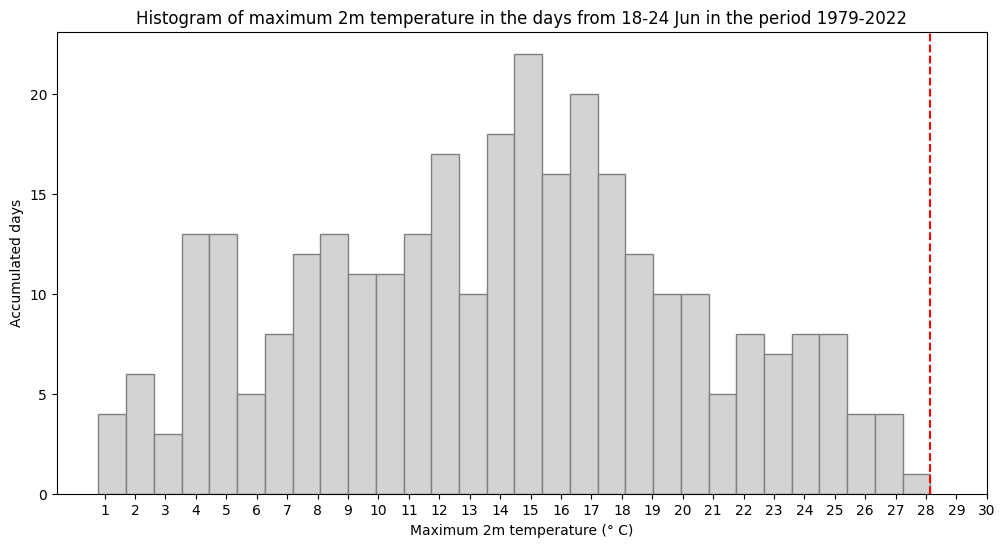

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.hist(x_7days, bins = 30, color='lightgrey', ec='grey')
ax.set_title('Histogram of maximum 2m temperature in the days from 18-24 Jun in the period 1979-2022')
ax.set_xticks(np.arange(1,31,1))
ax.set_ylabel('Accumulated days')
ax.set_xlabel('Maximum 2m temperature (° C)')
plt.axvline(x = x_2020_max.max(), color = 'red', label = 'axvline - full height', linestyle='--')

**Fig.5**
*This plot shows the distribution of the maximum temperature on June 21+/- 3days from 1979 to 2020. The dashed red line represents the maximum temperature in 2020. It shows that the record on 21 June, 2020 is still the highest compared to the others.*

## **Event 2 : Western North America Heatwave -- Lytton Wildfire**
In the summer of 2021, the Northwest experienced record-breaking high temperatures from late June through mid-July. The heat wave affected Oregon, Washington, Idaho, northern California, western Nevada, and British Columbia. Temperature records were broken by several degrees in many cities in the Northwest. In 2021, it was one of the most extreme events recorded globally. The regional average daily maximum temperature was nearly 30°F hotter than the mean of the hottest 3 months in the previous decade, and the highest temperature was 61°F(=16.11℃) hotter. *Canada recorded a record temperature in British Columbia (121.3°F, = 49.61℃), which is higher than the hottest temperatures ever recorded in many states, including Texas (120°F, 48.89℃).*

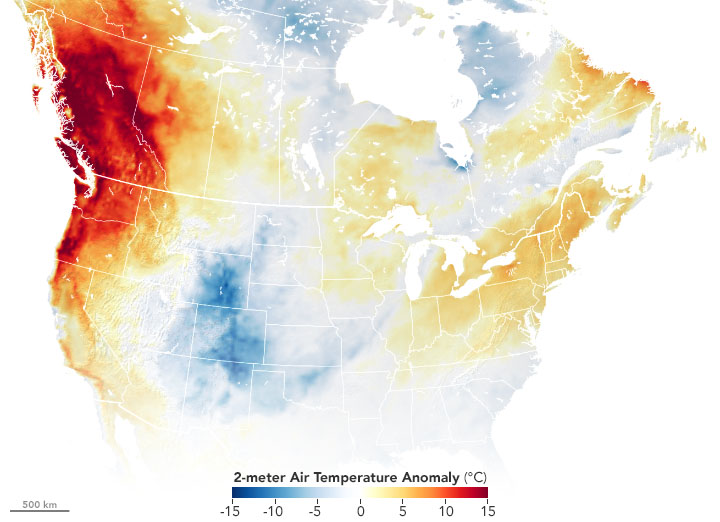

**Fig.6**
*A map of the magnitude of temperature anomalies–temperature that was higher or lower than the long-term average-that occurred during the 2021 heat dome. (Courtesy of NASA Earth Observator)*

A *wildfire* began on June 30, 2021 just south of the village of *Lytton* in the interior of British Columbia, Canada. The fire destroyed much of Lytton and two residents were confirmed dead from the event. The fire, one of the 2021 British Columbia wildfires throughout the province, was facilitated by the 2021 Western North America Heatwave.

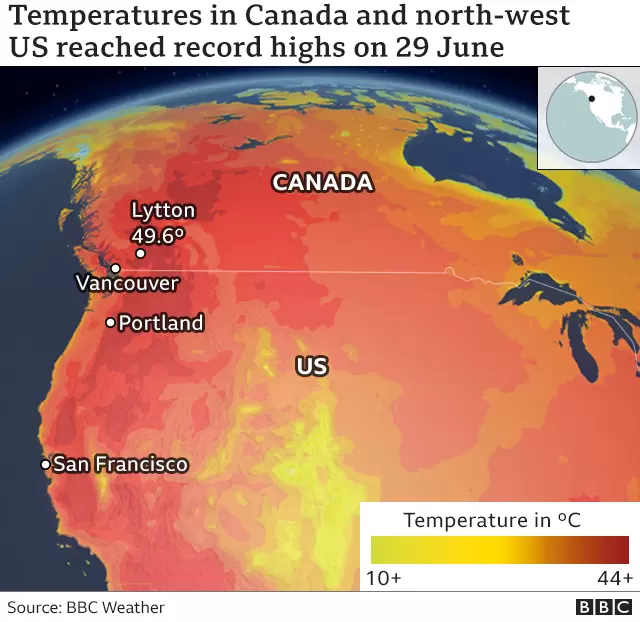

**Fig.7**
*A map showing the temperature distribution of the Northwest and the location of Lytton.*


In this case study I want to look at the temperature change in Lytton before after the wildfire happened.

Reference:

https://www.climatehubs.usda.gov/hubs/northwest/topic/2021-northwest-heat-dome-causes-impacts-and-future-outlook

https://www.nytimes.com/2021/07/10/world/canada/canadian-wildfire-british-columbia.html

https://en.wikipedia.org/wiki/Lytton_wildfire

https://www.cbc.ca/news/canada/british-columbia/lytton-wildfire-sat-update-1.6089367

https://www.bbc.com/news/world-us-canada-57678054


Paper Reference:

White, R.H., Anderson, S., Booth, J.F. et al. The unprecedented Pacific Northwest heatwave of June 2021. Nat Commun 14, 727 (2023).
https://doi.org/10.1038/s41467-023-36289-3

In [24]:
#Select the month(June-July) and Lytton(50N, 120W)
LT_t2m=ds.sel(time=ds.time.dt.month.isin([6, 7])).sel(lat=50, lon=240, method="nearest")
print(LT_t2m)

<xarray.Dataset>
Dimensions:  (time: 2684)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2022-07-31
    lon      float64 240.0
    lat      float64 50.0
Data variables:
    mx2t     (time) float32 20.71 22.83 22.08 19.3 ... 31.11 31.08 30.27 30.21
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Sep 05 13:41:31 2023: cdo chname,t2m,mx2t ERA5_SFC_mx2t...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...


/usr/local/lib/python3.10/dist-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [25]:
LT_mx2t = LT_t2m['mx2t']
print(LT_mx2t)

<xarray.DataArray 'mx2t' (time: 2684)>
array([20.708862, 22.833313, 22.07721 , ..., 31.076324, 30.266815,
       30.210785], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2022-07-31
    lon      float64 240.0
    lat      float64 50.0


In [26]:
#filter 2021 June-July
LT_2021_max = LT_mx2t.sel(time=slice('2021-06-01', '2021-07-31'))
#now we got data only in the 61 days in June-July, 2021

Text(2021-06-30 12:00:00, 15, '← Wildfire Starting Point')

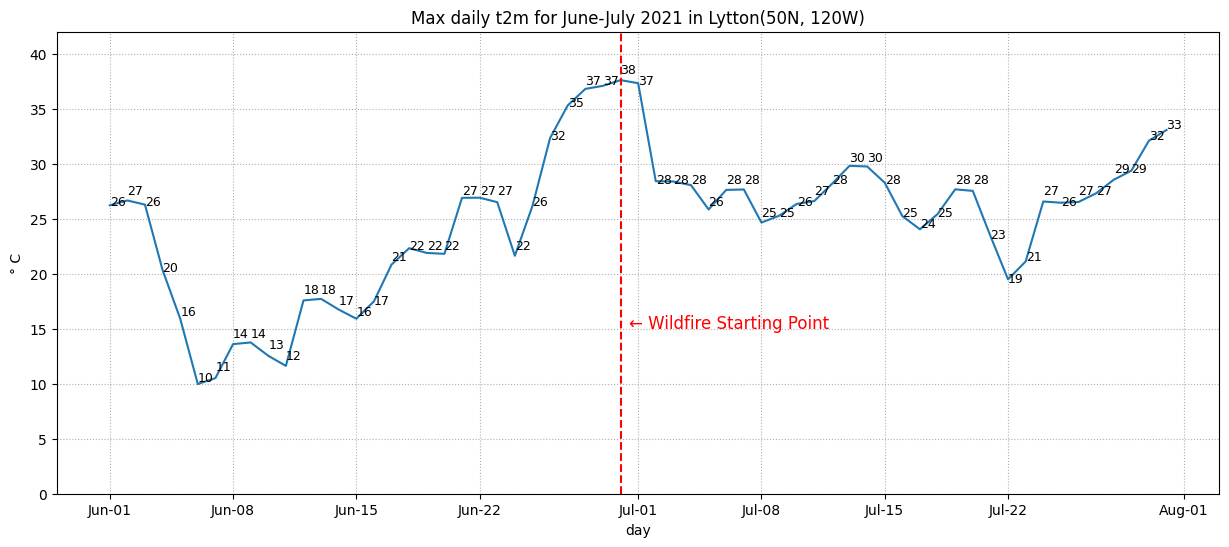

In [27]:
#a line plot that shows temperature fluctuation in June, 2002
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
ax.plot(LT_2021_max.time, LT_2021_max)
ax.set_ylim(0,42)
ax.set_title('Max daily t2m for June-July 2021 in Lytton(50N, 120W)')
ax.set_ylabel('° C')
ax.set_xlabel('day')
ax.grid(linestyle='dotted')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
#put the max.T value on each point
for i,j in zip(LT_2021_max.time, np.around(LT_2021_max.values, 0).astype(int)):
    ax.annotate(str(j),xy=(i,j+0.2),fontsize=9)
plt.axvline(pd.Timestamp('2021-06-30'), color = 'red', label = 'axvline - full height', linestyle='--')
ax.annotate('← Wildfire Starting Point', xy=(pd.Timestamp('2021-06-30 12:00:00'), 15), fontsize=12, color = 'red')

In [28]:
print('The maximum temperature in June to July 2021 in this area was',
      np.around(LT_2021_max.max().values, 2), 'degrees Celsius.')

The maximum temperature in June to July 2021 in this area was 37.6 degrees Celsius.


**Fig.7**
*This plot shows the temperature variation from June 2020 to July 2020 at the location (67.5N, 130E), represented by the daily maximum two-meter temperature. The red dashed line marked the date on which the wildfire happened, 30 June, which is also the date that had the highest maximum temperature, 37.6°C. From this plot we can see there was an unsual surge in tenperature from 24 June to 1 July.*

In [29]:
#select data before 2021(included)
LT_past = LT_mx2t.loc['1979':'2021']
print(LT_past[0])

<xarray.DataArray 'mx2t' ()>
array(20.708862, dtype=float32)
Coordinates:
    time     datetime64[ns] 1979-06-01
    lon      float64 240.0
    lat      float64 50.0


In [30]:
#select 10, 50, 90 quantile from the past
years = np.arange(42)
days_in_jj = np.arange(0,62)
index = []
index_1 = np.zeros(42)

#calculate the index that marks those days
for j in days_in_jj:
  for i in years:
    index_1[i] = j+61*i
  index_1 = [int(x) for x in index_1]
  index.append(index_1)
  index_1 = np.zeros(42)

LT_max_10 = []
for i in range(61):
    my_dt = LT_past[index[i]]
    percentiles_for_date = np.percentile(my_dt, 10)
    LT_max_10.append(percentiles_for_date)


LT_max_mid = []
for i in range(61):
    my_dt = LT_past[index[i]]
    percentiles_for_date = np.percentile(my_dt, 50)
    LT_max_mid.append(percentiles_for_date)

LT_max_90 = []
for i in range(61):
    my_dt = LT_past[index[i]]
    percentiles_for_date = np.percentile(my_dt, 90)
    LT_max_90.append(percentiles_for_date)

print(LT_max_10)
print(LT_max_mid)
print(LT_max_90)

[10.994692993164062, 11.765631103515625, 12.149215698242188, 11.764108276367187, 11.652984619140625, 10.333157348632813, 10.793307495117189, 10.738314819335937, 12.448153686523439, 12.217510986328126, 11.10562744140625, 12.458465576171875, 11.714199829101563, 11.079266357421876, 12.334097290039063, 13.0552978515625, 14.242532348632812, 12.828451538085938, 12.837661743164062, 12.607714843750001, 13.39044189453125, 13.122607421875, 13.687237548828126, 13.519900512695312, 14.385711669921875, 14.36651611328125, 15.345901489257812, 14.444088745117188, 15.505618286132812, 14.187411499023439, 13.417630004882813, 13.920059204101562, 14.735470581054688, 12.695785522460938, 14.91624755859375, 15.594503784179688, 15.280615234375, 15.120449829101563, 16.014105224609374, 16.32561340332031, 15.926150512695312, 15.764825439453126, 16.013330078125, 15.945962524414062, 15.440435791015625, 14.335983276367188, 17.086090087890625, 16.87708435058594, 17.220278930664062, 16.798583984375, 16.74208984375, 18.

<ipython-input-31-fff774e98c1a>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  ax.plot(np.arange(1,62), LT_2021_max, 'bo-', color='darkred', label='Daily max t2m June-July 2021')


Text(30.5, 10, '← Wildfire Starting Point')

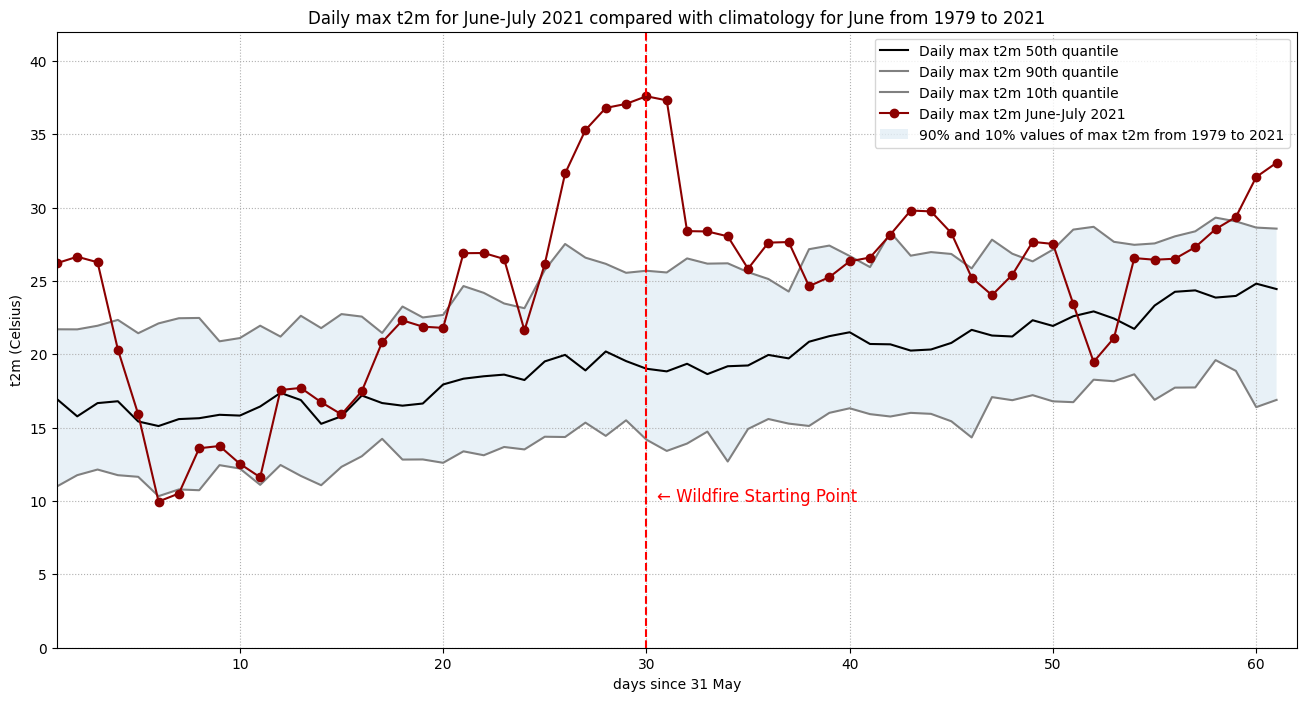

In [31]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()
ax.plot(np.arange(1,62) , LT_max_mid, color='black', label='Daily max t2m 50th quantile')
ax.plot(np.arange(1,62), LT_max_90, color='gray', label='Daily max t2m 90th quantile')
ax.plot(np.arange(1,62), LT_max_10, color='gray', label='Daily max t2m 10th quantile')
ax.plot(np.arange(1,62), LT_2021_max, 'bo-', color='darkred', label='Daily max t2m June-July 2021')
ax.fill_between(np.arange(1,62), LT_max_90, LT_max_10, alpha=0.1,
                label='90% and 10% values of max t2m from 1979 to 2021')

ax.set_xlim(1,62)
ax.set_ylim(0,42)
ax.set_title('Daily max t2m for June-July 2021 compared with climatology for June from 1979 to 2021')
ax.set_ylabel('t2m (Celsius)')
ax.set_xlabel('days since 31 May')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='dotted')
plt.axvline(x = 30, color = 'red', label = 'axvline - full height', linestyle='--')
ax.annotate('← Wildfire Starting Point', xy=(30.5, 10), fontsize=12, color = 'red')

**Fig.8**
*This plot shows the temperature variation from June 2021 to July 2021 compared to previous years, showing the historical temperature range for this location from June-July 1979 to June-July 2021, with the upper and lower bounds corresponding to the 90th and 10th quantiles, respectively. There was a period of extremely high tempeature from 26, June to 31 June, almost twice the interval from 10th to 90th quantile, and within it the wildfire occured. There were also several relatively "small" heatwave events(e.g. at day 21-23 and 43-45 since 31 May) before and after the wildfire.*

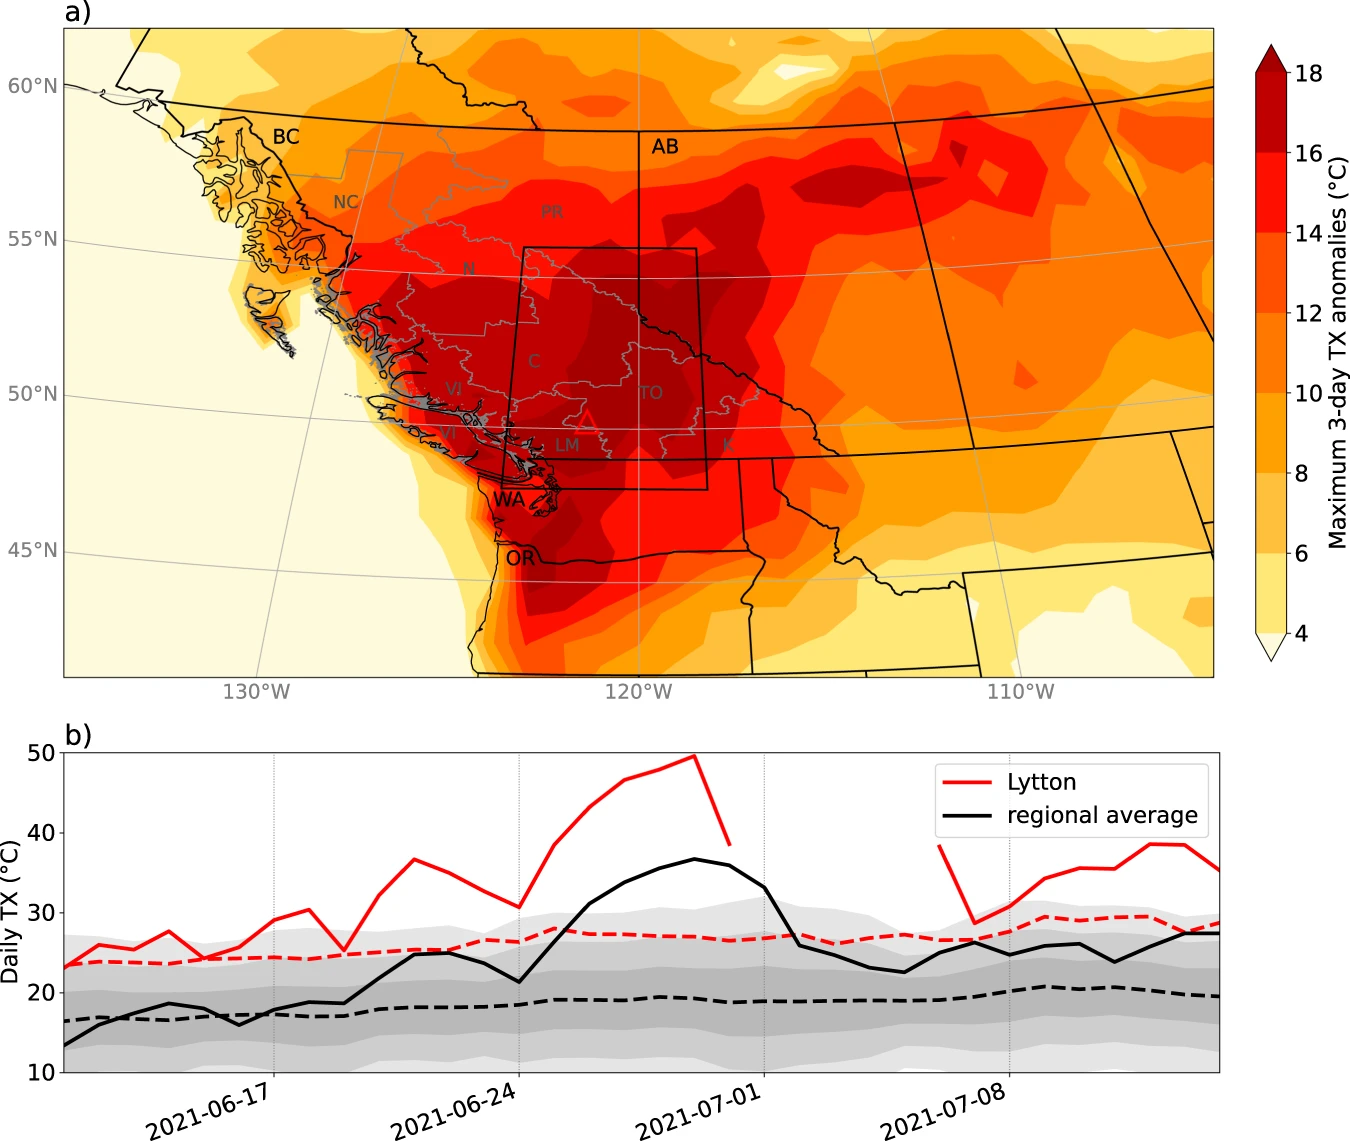

**Fig.9**
*a) ERA5 reanalysis data maximum 3-day running mean (between 23 June and 02 July 2021) of TX anomalies relative to a daily 1981–2020 climatology.*
*b) Absolute TX values for 2021 (solid) and 1981–2020 climatology (dashed); black lines: spatial average of ERA5 data over the black box in a, with shading ±1, 2, and 3 standard deviations; red lines: observations from Lytton, British Columbia (BC), denoted by the red triangle in a.*
(White, R.H., Anderson, S., Booth, J.F. et al, 2023)

Then we will inspect the probability distribution of maximum temperatures for 30 June in this time period. To do this, we will first select only the max daily temperature for 30 June, for each year in the time series:

In [32]:
#selct only data on 30 June
LT_JUN_30 = LT_mx2t[29::61] #start from index 30, for an interval of 61
print(LT_JUN_30)

<xarray.DataArray 'mx2t' (time: 44)>
array([26.736267, 14.611237, 17.665588, 17.003052, 16.579468, 12.724762,
       22.477203, 20.595581, 28.785461, 13.353516, 14.14032 , 21.338501,
       16.26181 , 16.201508, 16.732483, 20.05365 , 24.319946, 18.910248,
       15.13623 , 22.690521, 13.517273, 19.22873 , 20.099304, 13.396179,
       25.765411, 23.894318, 20.22815 , 24.518097, 16.432526, 29.853271,
       18.4581  , 14.863403, 14.614532, 17.030151, 24.639618, 19.12851 ,
       25.131805, 24.106201, 26.063568, 16.07309 , 19.172638, 18.91629 ,
       37.600677, 17.202057], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-06-30 1980-06-30 ... 2022-06-30
    lon      float64 240.0
    lat      float64 50.0


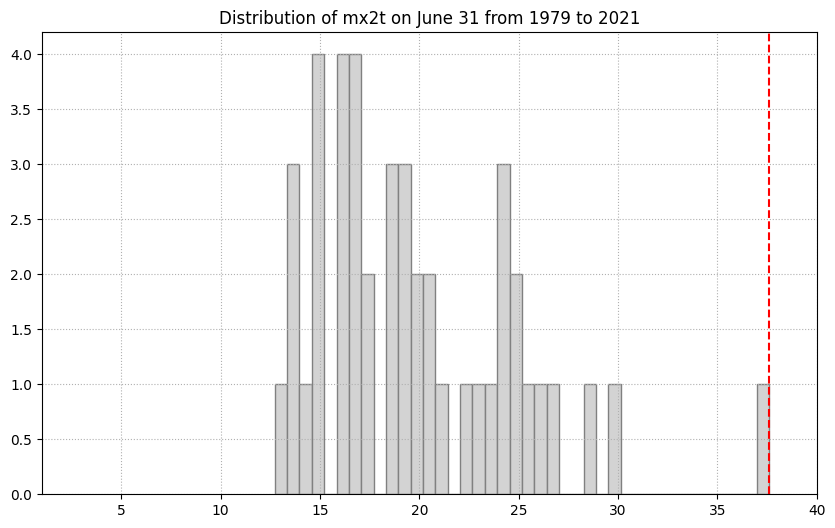

In [33]:
#plot the probability distribution
fig = plt.figure(figsize=(10,6))
ax = plt.subplot()
ax.hist(LT_JUN_30, color='lightgrey', ec='grey',  bins=40)
ax.set_xlim(1,40)
ax.set_title('Distribution of mx2t on June 31 from 1979 to 2021')
plt.axvline(x = LT_2021_max.max(), color = 'red', label = 'axvline - full height', linestyle='--')
ax.grid(linestyle='dotted')

**Fig.10**
*This plot shows the distribution of the maximum temperature on June 30 from 1979 to 2020. There are 44 samples. The dashed red line represents the maximum temperature in 2021 -- it is apparent that the temperature in the past has never exceeded it. Furthermore, it is on the far right end of the chart, keeping a distance from the other samples, indicating it is an extremely rare case.*

In order to increase the number of samples, let's plot the histogram of maximum temperatures on 30 June, plus or minus three days(which are, 27 June to 2 July). This would increase our number of samples by a factor of seven.

In [34]:
years = np.arange(44) #2022-1979=43 years
days_in_interval = np.arange(27,34)
index = np.zeros(308) #44*7

In [35]:
#calculate the index that marks those days
for i in years:
    index[i*7:(i*7)+7] = days_in_interval + (i*61)
index = index.astype(int)
print(index)
print(type(index[1]))

[  27   28   29   30   31   32   33   88   89   90   91   92   93   94
  149  150  151  152  153  154  155  210  211  212  213  214  215  216
  271  272  273  274  275  276  277  332  333  334  335  336  337  338
  393  394  395  396  397  398  399  454  455  456  457  458  459  460
  515  516  517  518  519  520  521  576  577  578  579  580  581  582
  637  638  639  640  641  642  643  698  699  700  701  702  703  704
  759  760  761  762  763  764  765  820  821  822  823  824  825  826
  881  882  883  884  885  886  887  942  943  944  945  946  947  948
 1003 1004 1005 1006 1007 1008 1009 1064 1065 1066 1067 1068 1069 1070
 1125 1126 1127 1128 1129 1130 1131 1186 1187 1188 1189 1190 1191 1192
 1247 1248 1249 1250 1251 1252 1253 1308 1309 1310 1311 1312 1313 1314
 1369 1370 1371 1372 1373 1374 1375 1430 1431 1432 1433 1434 1435 1436
 1491 1492 1493 1494 1495 1496 1497 1552 1553 1554 1555 1556 1557 1558
 1613 1614 1615 1616 1617 1618 1619 1674 1675 1676 1677 1678 1679 1680
 1735 

In [36]:
#extract the data from those days
LT_7days = LT_mx2t.values[index]
print(LT_7days)

[26.20758   26.627441  26.736267  11.327179  12.015137  18.5654
 20.313995  16.862396  16.352844  14.611237  20.842468  20.990479
 18.624298  12.458191  18.769257  18.154816  17.665588  17.53302
 23.941315  25.075531  25.149261  18.77066   18.723145  17.003052
 16.493011  16.452515  16.496887  10.880646  20.656677  20.514282
 16.579468  16.55954   11.2751465 13.889008  20.440796  21.947418
 19.1828    12.724762  11.909454  18.257355  20.389801  19.823944
 21.98999   22.97403   22.477203  22.39209   23.965027  26.821198
 27.814636  22.891632  18.467651  20.595581  20.872314  15.642853
 15.774811  12.474396  25.884735  28.257538  28.785461  28.549469
 28.069153  25.858948  20.167877  16.498444  16.331696  13.353516
 14.709412  15.64386   15.468903  14.834686  14.376404  14.57251
 14.14032   13.27063   15.714569  16.339478  16.096039  17.403564
 21.146301  21.338501  17.028473  15.474457  16.233887  20.197021
 20.209839  20.056763  16.26181   21.379608  26.556976  26.537933
 24.154846  27

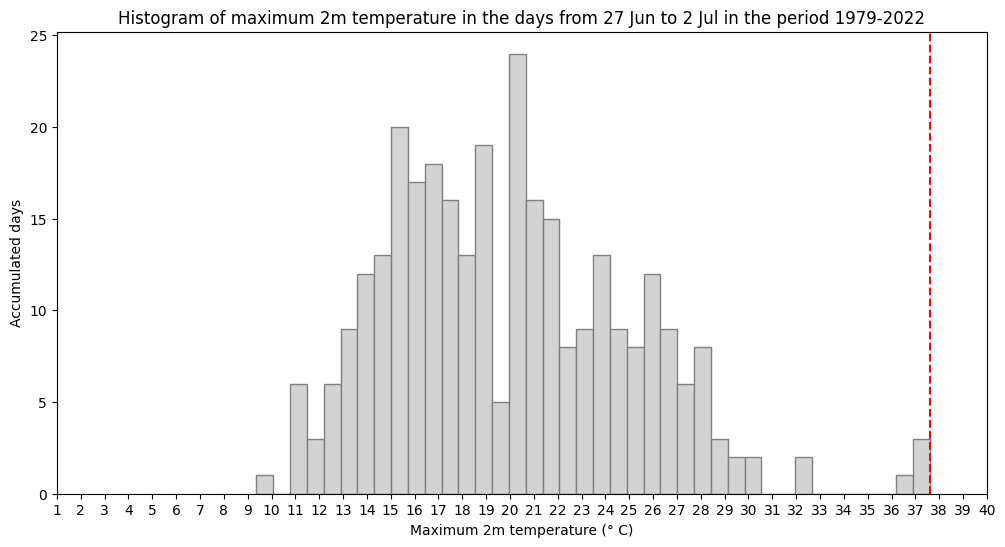

In [37]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.hist(LT_7days, bins = 40, color='lightgrey', ec='grey')
ax.set_title('Histogram of maximum 2m temperature in the days from 27 Jun to 2 Jul in the period 1979-2022')
ax.set_xticks(np.arange(1,41,1))
ax.set_ylabel('Accumulated days')
ax.set_xlabel('Maximum 2m temperature (° C)')
plt.axvline(x = LT_2021_max.max(), color = 'red', label = 'axvline - full height', linestyle='--')

**Fig.11**
*This plot shows the distribution of the maximum temperature on 27 June to two July from 1979 to 2022. It shows a similar result as Fig.9 -- that the extremely high temperature on 31, June, 2021 is the highest of this time period in the history.*

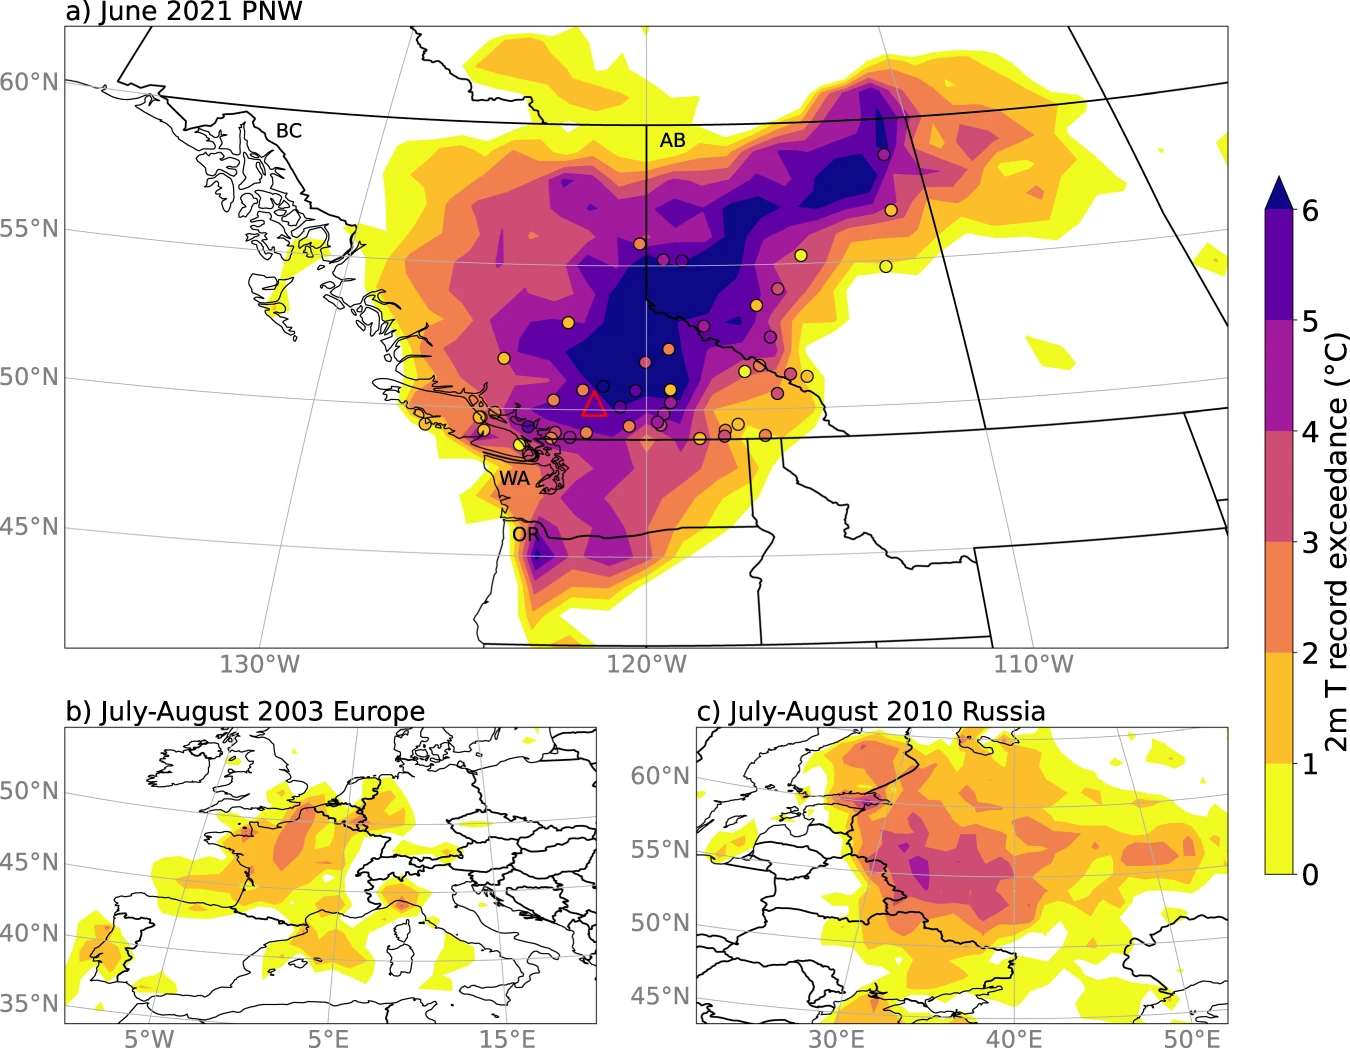

**Fig.12**
*Exceedance of previous record high temperatures during a the June 2021 Pacific Northwest heatwave, b the July–August European heatwave of 2003, and c the July–August Russian heatwave of 2010. Filled contours show ERA5 since 1950, whilst individual markers show observational station data in Canada; see Methods for record lengths.*

(White, R.H., Anderson, S., Booth, J.F. et al, 2023)